# Deep Learning: More Recurrent Neural Networks

In [3]:
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, LabelField, BucketIterator
from torchtext.datasets import SST
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(12)

print(f"Pytorch version: {torch.__version__}")
print(f"Torchtext version: {torchtext.__version__}")

Pytorch version: 2.9.1+cpu
Torchtext version: 0.6.0



### Note: Python must be 3.11.x

If your kernel shows a value > 3.11.x you will need to downgrade. Please email the staff for help

In [2]:
%pip install torchtext

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 15.7 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [sentencepiece]
   -------------------- ------------------- 1/2 [torchtext]
   -------------------- ------------------- 1/2 [torchtext]
   ---------------------------------------- 2/2 [torchtext]

Note: you may need to restart the kernel to use updated packages.


In [4]:
# DEVICE CONFIGURATION
if torch.backends.mps.is_available():          # Apple Silicon
    device = torch.device("mps")
elif torch.cuda.is_available():                # CUDA GPU
    device = torch.device("cuda")
else:
    device = torch.device("cpu")               # Fallback

print("Using device:", device)

Using device: cpu


In [5]:
# Define field types
TEXT = Field(tokenize='basic_english', lower=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

# Load SST data
train_data, _, test_data = SST.splits(
    TEXT, LABEL, fine_grained=False
)

downloading trainDevTestTrees_PTB.zip


.data\sst\trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:00<00:00, 2.13MB/s]


extracting


In [6]:
# Display size of datasets
print("Train size:", len(train_data))
print("Test size:", len(test_data))

Train size: 8544
Test size: 2210


The `.splits` method is splitting up our dataset so that our train and test sets both have representative samples. 

The `fine_grained` parameter determines how many categories our data is broken into.
- if `True`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2, 'very positive': 3, 'very negative': 4}
- if `False`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2}

In [7]:
# Build vocabulary
MAX_VOCAB_SIZE = 10000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

vocab = TEXT.vocab.stoi
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

### Q: What variable type is `vocab`? What does the `.build_vocab` method do?
Hint: `.stoi` stand for "string to int"!

### A: 
Vocab is a dictionary type. Build voca scans throuhg the entire dataset to create a vocabualry list. It keeps the most frequent words.

In [8]:
def decode_dataset(dataset):
    # Reverse label mapping: string -> int
    label_stoi = LABEL.vocab.stoi
    texts = [example.text for example in dataset] 
    labels = [label_stoi[example.label] for example in dataset]
    return texts, labels

train_texts, train_labels = decode_dataset(train_data)
test_texts, test_labels   = decode_dataset(test_data)

### Sanity Check 🧠 
Let's check that the decoded dataset makes sense!

In [9]:
label_map = {idx: word for word, idx in LABEL.vocab.stoi.items()}

# Change i and see what happens!
i = 0

print(" ".join(test_texts[i]))
print(label_map[test_labels[i]])

effective but too-tepid biopic
neutral


----

Now let's define a `BucketIterator`:

In [10]:
BATCH_SIZE = 32
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device
)

Below is a custom classifier:

In [11]:
# Custom LSTM Classifier
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len] if batch_first=True
        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]

        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # hidden: [1, batch_size, hidden_dim]  -> take the last hidden state
        return self.fc(hidden.squeeze(0))  # [batch_size, output_dim]

Here's a helper function so we can vary parameters later:

In [12]:
# TRAINING LOOP FUNCTION
def run_training_loop(num_epochs, random_state):
    # set random seed
    torch.manual_seed(random_state)

    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1

    # Send model to device
    model = SimpleLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pad_idx).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # init output vars
    train_losses = []
    train_accs = []

    # train for num_epochs
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        # Wrap the iterator with tqdm
        for batch in tqdm(train_iterator, desc=f"Epoch {epoch+1}/{num_epochs}"):
            text, text_lengths = batch.text
            labels = batch.label

            text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(text, text_lengths).squeeze(1)

            # Loss
            loss = criterion(predictions, labels.float())
            loss.backward()
            optimizer.step()

            # Optional: compute accuracy
            preds = torch.round(torch.sigmoid(predictions))
            acc = (preds == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        avg_loss = epoch_loss/ len(train_iterator)
        avg_acc = epoch_acc/ len(train_iterator)
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)
        print(f"Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}\n")
    return train_losses, train_accs, model

And another helper function plot the `train_losses` and `train_accs`:

In [13]:
def plot_training_performance(train_losses, train_accs, num_epochs, random_state):
    fig = plt.figure(figsize=(8,4), tight_layout=True)
    fig.suptitle(f"Model Training for State {random_state} over {num_epochs} Epochs")

    plt.subplot(1,2,1)
    plt.plot(train_losses, "-o", label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, "-o", label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()


Let's train our model!

In [14]:
NUM_EPOCHS = 15
RANDOM_STATE = 42
train_losses, train_accs, model = run_training_loop(NUM_EPOCHS, RANDOM_STATE)

Epoch 1/15: 100%|██████████| 267/267 [00:29<00:00,  8.91it/s]


Loss = 0.5133, Accuracy = 0.4055



Epoch 2/15: 100%|██████████| 267/267 [00:15<00:00, 17.43it/s]


Loss = 0.4339, Accuracy = 0.4422



Epoch 3/15: 100%|██████████| 267/267 [00:18<00:00, 14.57it/s]


Loss = 0.1299, Accuracy = 0.5277



Epoch 4/15: 100%|██████████| 267/267 [00:15<00:00, 17.00it/s]


Loss = -0.8654, Accuracy = 0.5545



Epoch 5/15: 100%|██████████| 267/267 [00:13<00:00, 19.22it/s]


Loss = -4.6180, Accuracy = 0.5955



Epoch 6/15: 100%|██████████| 267/267 [00:32<00:00,  8.27it/s]


Loss = -12.3446, Accuracy = 0.6379



Epoch 7/15: 100%|██████████| 267/267 [01:04<00:00,  4.13it/s]


Loss = -23.8768, Accuracy = 0.6602



Epoch 8/15: 100%|██████████| 267/267 [00:24<00:00, 10.92it/s]


Loss = -33.7167, Accuracy = 0.6552



Epoch 9/15: 100%|██████████| 267/267 [00:44<00:00,  6.01it/s]


Loss = -46.9673, Accuracy = 0.6850



Epoch 10/15: 100%|██████████| 267/267 [00:49<00:00,  5.35it/s]


Loss = -60.3287, Accuracy = 0.7015



Epoch 11/15: 100%|██████████| 267/267 [00:18<00:00, 14.83it/s]


Loss = -71.7336, Accuracy = 0.7082



Epoch 12/15: 100%|██████████| 267/267 [01:01<00:00,  4.34it/s]


Loss = -84.0121, Accuracy = 0.7188



Epoch 13/15: 100%|██████████| 267/267 [01:04<00:00,  4.13it/s]


Loss = -96.6467, Accuracy = 0.7241



Epoch 14/15: 100%|██████████| 267/267 [01:05<00:00,  4.08it/s]


Loss = -106.8065, Accuracy = 0.7264



Epoch 15/15: 100%|██████████| 267/267 [01:02<00:00,  4.26it/s]

Loss = -119.5337, Accuracy = 0.7329



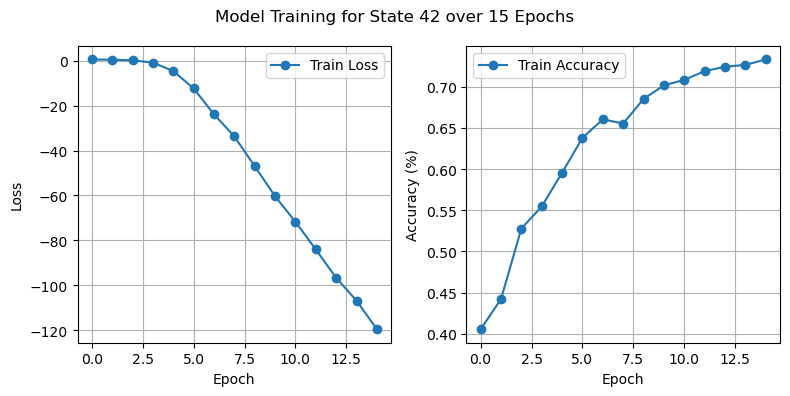

In [16]:
plot_training_performance(train_losses, train_accs, NUM_EPOCHS, RANDOM_STATE)

### Q: Try changing the value of `NUM_EPOCHS`. What happens to the train loss and accuracy plots? What does this tell us about the optimal number of training epochs?

### A: 
The more epochs there are, the accuracy will increase, however, the slope of that increase becomes less and less to when computation is not worth it for the tiny increase in accuracy, and also there could be overfitting. Training loss will decrease. It looks like 11 is a good number of epochs, because then the slope becomes close to 0, so more than that wouldnt be very beneficial. 

### Q: Try changing the value of `RANDOM_STATE`. What happens to the train loss and accuracy plots? What does this tell us about the impact of the initial guess (i.e. epoch 0)?

### A: 
The random state will only change the beggining, because it is like a random seed that determines what to do next, but the model also has to keep track of other things, so the pattern should generally stay the same. The inital guess can be lucky or unlucky( converge slower) but does not change it too much.

----

## Performance on the Test Set

Here's a helper function to run our model on the test data:

In [15]:

# Evaluate on test set
def run_evaluation_test():
    model.eval()
    test_loss, test_acc, = 0,0

    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            labels = batch.label

            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)

            criterion = nn.BCEWithLogitsLoss()
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels.float())

            preds = torch.round(torch.sigmoid(predictions))
            acc = (preds == labels).float().mean()

            test_loss += loss.item()
            test_acc += acc.item()

    return print(f"Test Accuracy: {100 * test_acc / len(test_iterator):.2f}%")


Finally, let's check that our model can generalize by processing the test data:

In [17]:
run_evaluation_test()

Test Accuracy: 56.03%


----
## Further Exploration 🔎

### Q: What happens to the **test** accuracy as `NUM_EPOCHS` is changed? What does this tell us about our neural network?
Note: remember to re-train your model before running on the test set!

### A:
More epochs will initally increase the accuracy, but to the point of dimishing returns, and even decrease due to overfitting. It might be way to fit to the test data and not to the training data.

### Q: What happens to the **test** accuracy as `RANDOM_STATE` is changed? What does this tell us about our neural network?
Note: remember to re-train your model before running on the test set!

### A:
It might change slightly, because some needs are intially slower to converge and would not be the same results in the same time, it shows the NN is sensitive to the original seed.

### Q: What happens to your results if you set `find_grained=True`?
Try to predict first and then test your hypothesis by changing the value and re-running the notebook!

### A: 
The accuracy will drop a bunch because the greater there are categories, with even more subtle differences, will be much harder for the model to guess. There are too many different things to keep track of, so I believe the model will struggle, it did.